In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp gdrive/My\ Drive/Tesis_Resources/corpus/Video.mp4 .
!cp gdrive/My\ Drive/Tesis_Resources/yolo/yolo.zip .

In [8]:
import cv2
vidcap = cv2.VideoCapture('Video.mp4') # Video.mp4
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  count += 1

frames = vidcap.get(cv2.CAP_PROP_POS_FRAMES)
segundos = vidcap.get(cv2.CAP_PROP_POS_MSEC) / 1000
frames_segundos = round(frames/segundos)

print(frames)
print(segundos)
print(frames_segundos)

862.0
35.95258333333333
24


In [9]:
!unzip yolo.zip

Archive:  yolo.zip
   creating: config/
  inflating: config/coco.data        
  inflating: config/coco.names       
  inflating: config/download_weights.sh  
  inflating: config/yolov3-tiny.cfg  
  inflating: config/yolov3.cfg       
  inflating: config/yolov3.weights   
   creating: images/
  inflating: images/blueangels-det.jpg  
  inflating: images/blueangels.jpg   
  inflating: images/Intersection-Counts.jpg  
  inflating: images/olympic-trials.jpg  
   creating: utils/
  inflating: utils/datasets.py       
  inflating: utils/parse_config.py   
  inflating: utils/utils.py          
   creating: utils/__pycache__/
  inflating: utils/__pycache__/datasets.cpython-36.pyc  
  inflating: utils/__pycache__/parse_config.cpython-36.pyc  
  inflating: utils/__pycache__/utils.cpython-36.pyc  
  inflating: utils/__pycache__/__init__.cpython-36.pyc  
  inflating: models.py               
  inflating: object_tracker.py       
  inflating: sort.py                 


In [0]:
from models import *
from utils import *
import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import seaborn as sb
from matplotlib.image import NonUniformImage

In [14]:
config_path='config/yolov3.cfg'
weights_path='config/yolov3.weights'
class_path='config/coco.names'
img_size=416
conf_thres=0.5
nms_thres=0.8

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor



/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [0]:
#Método para detectar la imagen
def detect_image(img, i):
  flag = False
  # scale and pad image
  ratio = min(img_size/img.size[0], img_size/img.size[1])
  imw = round(img.size[0] * ratio)
  imh = round(img.size[1] * ratio)
  img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
       transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                      (128,128,128)),
       transforms.ToTensor(),
       ])
  # convert image to Tensor
  image_tensor = img_transforms(img).float()
  image_tensor = image_tensor.unsqueeze_(0)
  input_img = Variable(image_tensor.type(Tensor))
  # run inference on the model and get detections
  with torch.no_grad():
      detections = model(input_img)
      detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres) #80
      #print('detections')
      #print(detections)
  if detections[0] is not None:
    for detection in detections[0]:
      x1, y1, x2, y2, conf, cls_conf, cls_pred = detection
      if cls_pred.item() == 0.0:
        #print('detection')
        #print(detection)
        #list_detections.append(detection)
        flag = True
        break
  if flag:
    return detections[0]
          


In [17]:
import math
# Iterador de imágenes

segundos = 70 #math.trunc(segundos) #70 # >
frames_segundos = 12 #frames_segundos # 12 # <

list_detections = []
list_detections_acc = []
x_number_list = []
y_number_list = []
detection_position = []

j = 0

for i in range(0 * frames_segundos, segundos * frames_segundos): # 271 862
  img_path = 'frame' + str(i) + '.jpg'
  img = Image.open(img_path)
  np_img = np.array(img)
  
  if i == 0:
    pad_x = max(np_img.shape[0] - np_img.shape[1], 0) * (img_size / max(np_img.shape))
    pad_y = max(np_img.shape[1] - np_img.shape[0], 0) * (img_size / max(np_img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
  
  #
  
  detections = detect_image(img, i)
  if detections is not None:
    puntos_por_detections = []
    
    for detection in detections:
      x1, y1, x2, y2, conf, cls_conf, cls_pred = detection
      if cls_pred.item() == 0.0:
        #print('detection')
        #print(detection)
        box_h = ((y2 - y1) / unpad_h) * np_img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * np_img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * np_img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * np_img.shape[1]

        x = (x1 + box_w/2).item()
        y = (y1 + box_h).item()  #aas

        puntos_por_detections.append(x)
        puntos_por_detections.append(y)

        
        if (i+1) % frames_segundos != 0:

          if len(list_detections_acc) == 0:
             list_detections_acc = puntos_por_detections
          else:
            list_detections_acc = list(map(sum, zip(puntos_por_detections, list_detections_acc)))
            j = j + 1
            #print('j ' + str(j))
          #print(list_detections_acc)
        break

  if (i+1) % frames_segundos == 0 and j !=0 :

    for k in range(0, int(len(list_detections_acc)/2)):

      if k%2 == 0:
        list_detections.append((list_detections_acc[k]/j,list_detections_acc[k+1]/j)) 
        list_detections_acc = []
    j = 0  
  
print(list_detections) # print(detection_position)

[(183.15656389508928, 539.0924377441406), (181.6994514465332, 543.9071846008301), (166.95783386230468, 530.1237335205078), (161.57546997070312, 518.2132263183594), (204.83450317382812, 686.7527160644531), (282.86363728841144, 780.7925923665365), (356.2620162963867, 767.4131011962891), (447.4840911865234, 795.3392211914063), (525.021630859375, 794.5090637207031), (444.7838928222656, 816.8305541992188), (314.9316680908203, 780.0195861816406), (324.1111348470052, 897.6747233072916), (190.00037002563477, 744.9022369384766), (261.4487594604492, 762.5530822753906), (430.3505859375, 786.8816162109375), (666.4834228515625, 795.2289001464844)]


In [0]:
x_number_list = []
y_number_list = []
j = 0
for detection in list_detections:
  if detection is not None:
    x, y = detection
    #x1, y1, x2, y2, conf, cls_conf, cls_pred = detection
    #box_h = ((y2 - y1) / unpad_h) * np_img.shape[0]
    #box_w = ((x2 - x1) / unpad_w) * np_img.shape[1]
    #y1 = ((y1 - pad_y // 2) / unpad_h) * np_img.shape[0]
    #x1 = ((x1 - pad_x // 2) / unpad_w) * np_img.shape[1]

    #x_number_list.append(x1.item())
    #y_number_list.append(y1.item()) #detection.cpu().numpy()[1]

    x_number_list.append(x)
    y_number_list.append(y) #detection.cpu().numpy()[1]

In [19]:
print('Número de detecciones: ' + str(len(list_detections)))
print(len(x_number_list))
print(x_number_list)
print(y_number_list)

Número de detecciones: 16
16
[183.15656389508928, 181.6994514465332, 166.95783386230468, 161.57546997070312, 204.83450317382812, 282.86363728841144, 356.2620162963867, 447.4840911865234, 525.021630859375, 444.7838928222656, 314.9316680908203, 324.1111348470052, 190.00037002563477, 261.4487594604492, 430.3505859375, 666.4834228515625]
[539.0924377441406, 543.9071846008301, 530.1237335205078, 518.2132263183594, 686.7527160644531, 780.7925923665365, 767.4131011962891, 795.3392211914063, 794.5090637207031, 816.8305541992188, 780.0195861816406, 897.6747233072916, 744.9022369384766, 762.5530822753906, 786.8816162109375, 795.2289001464844]


In [0]:
def draw_multiple_points():

    # Draw point based on above x, y axis values.
    plt.scatter(x_number_list, y_number_list, s=10)

    # Set chart title.
    plt.title("Extract Number Root ")

    # Set x, y label text.
    plt.xlabel("Number")
    plt.ylabel("Extract Root of Number")
    plt.xlim(0, 1280 * 1.1)
    plt.ylim(0, 720 * 1.1)
    ax=plt.gca() 
    ax.invert_yaxis()
    plt.show()

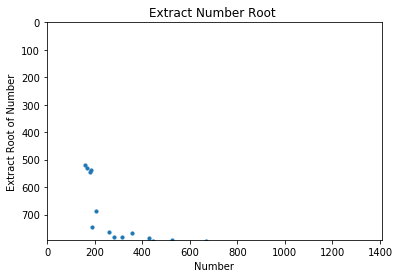

In [21]:
# Plotear los puntos en una imagen

draw_multiple_points()

<Figure size 432x288 with 0 Axes>

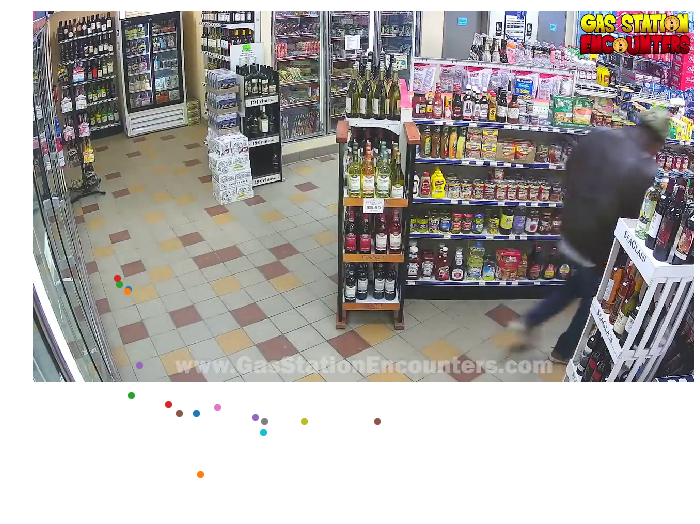

In [22]:
img_path = 'frame' + str(int(frames)-1) + '.jpg'
img = Image.open(img_path)
np_img = np.array(img)

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(np_img)


i = 0
if list_detections is not None:
    #unique_labels = list_detections.cpu().unique()
    #n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, 1)
    # browse detections and draw bounding boxes
    for x, y in list_detections:
       # i = i + 1
       # box_h = ((y2 - y1) / unpad_h) * np_img.shape[0]
       # box_w = ((x2 - x1) / unpad_w) * np_img.shape[1]
       # y1 = ((y1 - pad_y // 2) / unpad_h) * np_img.shape[0]
       # x1 = ((x1 - pad_x // 2) / unpad_w) * np_img.shape[1]
        color = (0.5176470588235295, 0.23529411764705882, 0.2235294117647059, 1.0) #bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        #bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.scatter(x , y) #(y1 + box_h/2).item()
        #ax.add_patch(bbox)
        #plt.text(x1, y1, s=classes[int(cls_pred)] + str(i), color='white', verticalalignment='top',
                #bbox={'color': color, 'pad': 0})
plt.axis('off')
# save image
plt.savefig('frame0.jpg'.replace(".jpg", "-det.jpg"), bbox_inches='tight', pad_inches=0.0)
plt.show()

ValueError: ignored

<Figure size 432x288 with 0 Axes>

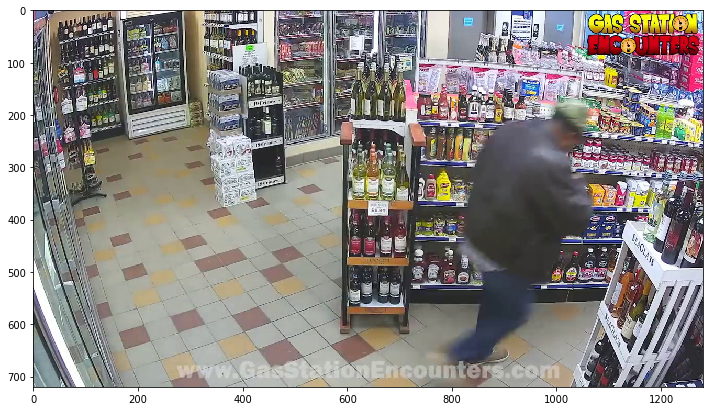

In [98]:
img_path = 'frame' + str(850) + '.jpg'
img = Image.open(img_path)
np_img = np.array(img)

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(np_img)


i = 0
if list_detections is not None:
    #unique_labels = list_detections.cpu().unique()
    #n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, 1)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in list_detections:
        i = i + 1
        box_h = ((y2 - y1) / unpad_h) * np_img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * np_img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * np_img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * np_img.shape[1]
        color = (0.5176470588235295, 0.23529411764705882, 0.2235294117647059, 1.0) #bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        #bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.scatter((x1 + box_w/2).item(),(y1 + box_h).item()) #(y1 + box_h/2).item()
        #ax.add_patch(bbox)
        #plt.text(x1, y1, s=classes[int(cls_pred)] + str(i), color='white', verticalalignment='top',
                #bbox={'color': color, 'pad': 0})
plt.axis('off')
# save image
plt.savefig('frame0.jpg'.replace(".jpg", "-det.jpg"), bbox_inches='tight', pad_inches=0.0)
plt.show()